# Varying Batch Size

In [16]:
# Imports
import numpy as np

import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

import matplotlib.ticker as mticker
import matplotlib.pyplot as plt 
%matplotlib inline

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Load data
data_directory = 'D:/book-implementations/packt-modern-computer-vision-with-pytorch/3-building-deep-nn-with-pytorch/images/FMNIST'
fmnist = datasets.FashionMNIST(
    data_directory,
    download=False,
    train=True
    )

tr_images = fmnist.data
tr_targets = fmnist.targets 

val_fmnist = datasets.FashionMNIST(
    data_directory,
    download=False,
    train=False
    )

val_images = val_fmnist.data 
val_targets = val_fmnist.targets 

In [12]:
# Dataset
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1, 28*28)
        self.x = x 
        self.y = y 

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]

        return x.to(device), y.to(device)

# Model
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(
        model.parameters(),
        lr = 1e-2
    )

    return model, loss_fn, optimizer

In [14]:
# Training Function
def train_batch(x, y, model, loss_fn, optimizer):
    model.train()

    predictions = model(x)
    batch_loss = loss_fn(predictions, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return batch_loss.item()

# Validation
def accuracy(x, y, model):
    model.eval()

    with torch.no_grad():
        predictions = model(x)

    max_values, argmax = predictions.max(-1)

    is_correct = argmax == y 

    return is_correct.cpu().numpy().tolist()

In [8]:
# Get Data
def get_data():
    train_ds = FMNISTDataset(tr_images, tr_targets)
    train_dl = DataLoader(
        train_ds,
        batch_size = 32,
        shuffle=True

    )

    val_ds = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(
        val_ds,
        batch_size = len(val_images),
        shuffle=False
    )

    return train_dl, val_dl 

In [9]:
# Validation loss
@torch.no_grad()

def val_loss(x, y, model):
    model.eval()
    predictions = model(x)
    val_loss = loss_fn(predictions, y)
    return val_loss.item()

In [15]:
# Model Training

train_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(5):
    print(f"\nEpoch: {epoch}")
    train_epoch_losses, train_epoch_accuracies = [], []

    for index, batch in enumerate(iter(train_dl)):
        x, y = batch 
        batch_loss = train_batch(x, y, model, loss_fn, optimizer)
        train_epoch_losses.append(batch_loss)

    train_epoch_loss = np.array(train_epoch_losses).mean()

    for index, batch in enumerate(iter(train_dl)):
        x, y = batch 
        train_is_correct = accuracy(x, y, model)
        train_epoch_accuracies.append(train_is_correct)

    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    print(f"Loss: {train_epoch_loss}    Accuracy: {train_epoch_accuracy}")

    for index, batch in enumerate(iter(val_dl)):
        x, y = batch 
        val_is_correct = accuracy(x, y, model)
        val_batch_loss = val_loss(x, y, model)

    validation_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(val_batch_loss)
    val_accuracies.append(validation_epoch_accuracy)



Epoch: 0
Loss: 0.8482412863095602    Accuracy: 0.8074333333333333

Epoch: 1
Loss: 0.5388023504654567    Accuracy: 0.8283666666666667

Epoch: 2
Loss: 0.48426597578525543    Accuracy: 0.843

Epoch: 3
Loss: 0.45618132123152416    Accuracy: 0.8446666666666667

Epoch: 4
Loss: 0.4364000505288442    Accuracy: 0.8476666666666667


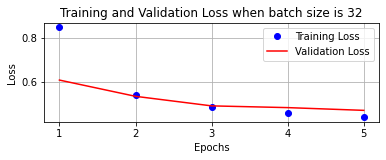

C:\Users\hp\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator


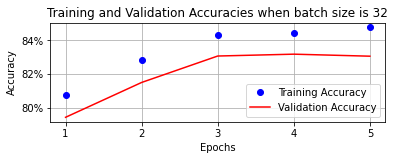

In [17]:
# Plots

epochs = np.arange(5) + 1

# ==================================
# Training and Validation Loss Plot
# ==================================
plt.subplot(211)
plt.plot(
    epochs, 
    train_losses,
    'bo',
    label='Training Loss'
    )
plt.plot(
    epochs,
    val_losses,
    'r',
    label='Validation Loss'
)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and Validation Loss when batch size is 32")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid('off')
plt.show()

# ==================================
# Training and Validation Accuracy Plot
# ==================================

plt.subplot(212)
plt.plot(
    epochs,
    train_accuracies,
    'bo',
    label='Training Accuracy'
)
plt.plot(
    epochs,
    val_accuracies,
    'r',
    label='Validation Accuracy'
)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and Validation Accuracies when batch size is 32")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()